In [98]:
import time
import numpy as np
import xgboost as xgb
import pandas as pd
import os
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import tree
import sklearn 
#xgboost part of this notebook follows {https://github.com/k-woodruff/bdt-tutorial} quite closely. 

In [40]:
muon_df =pd.read_feather("mum.feather") #read in muon and electron feather to pandas dataframe
print(f"Number of muon events in data set is {len(muon_df)}")

elec_df = pd.read_feather("electrons_large.feather")
print(f"Number of electron envents in data set is {len(elec_df)}")

Number of muon events in data set is 468196
Number of electron envents in data set is 303723


,energy,energy_cor,x,y,x_cor,y_cor,nhits,seed_e,seed_ix,seed_iy,pdg_id
0,0.208387,0.304703,164.917160,29.307570,176.880310,27.712893,2,0.107822,10,1,13
1,0.192105,0.235183,346.422363,-83.485344,351.167725,-82.910431,2,0.119773,22,-5,22
2,0.248797,0.346332,22.327135,42.953724,31.850431,42.022709,1,0.248797,-2,2,13
3,0.176096,0.264418,-58.985336,-42.069271,-47.597919,-40.178596,1,0.176096,-8,-2,13
4,0.174293,0.249070,-135.385635,-28.416124,-140.257568,-26.535488,2,0.113196,-14,-1,11


In [43]:
#create filtered dataframes only containing events that either start as an electron or a negative muon, respectively
ele_filt = elec_df.loc[elec_df['pdg_id']==11]
mum_filt = muon_df.loc[muon_df['pdg_id']==13]
#print(ele_filt.shape[0],mum_filt.shape[0]) 

#combine the filtered dataframes
combined_df = pd.concat([ele_filt, mum_filt], ignore_index=True)

#permute the combined dataframe to randomly mix the indices
shuffled_df= combined_df.sample(frac = 1)

#make sure shuffled df looks correct
print(f"Number of total shuffled events: {len(shuffled_df)}")
shuffled_df.head()


#split the shuffled df into a df for training the tree and a df for validating the tree's predictions
shuffled_training_df = shuffled_df.iloc[0:400000]
shuffled_validation_df = shuffled_df.iloc[400000:]

print(f"Number of shuffled events for training: {len(shuffled_training_df)}")
print(f"Number of shuffled events for validation: {len(shuffled_validation_df)}")


Number of total shuffled events: 576058
Number of shuffled events for training: 400000
Number of shuffled events for validation: 176058


In [45]:
for col in shuffled_training_df.columns:
    print(col)
print('Fraction e-/mu-: {}'.format(len(shuffled_training_df[shuffled_training_df.pdg_id == 11])/(float)(len(shuffled_training_df[shuffled_training_df.pdg_id == 13]) + len(shuffled_training_df[shuffled_training_df.pdg_id == 11]))))    

energy
energy_cor
x
y
x_cor
y_cor
nhits
seed_e
seed_ix
seed_iy
pdg_id
Fraction e-/mu-: 0.321085


In [78]:
#drop columns related to truth quantities and redundant features. Not dropping pdg_id yet, as xgboost uses this as the 'label' for the data
train_df = shuffled_training_df.drop(columns=['x','y','energy'])
val_df = shuffled_validation_df.drop(columns=['x','y','energy'])

#create an index of the columns that we want to be the features that the ML tree investigates as dependent variables
feature_names = train_df.columns[0:-1] #drop the pdg_id, as it is the independent variable in this context
print(feature_names)



Index(['energy_cor', 'x_cor', 'y_cor', 'nhits', 'seed_e', 'seed_ix',
       'seed_iy'],
      dtype='object')


In [79]:
train_df['pdg_id']=train_df['pdg_id'].astype('category') #set the pdg_id as a 'category' datatype for xgboost. 
val_df['pdg_id']=val_df['pdg_id'].astype('category')
train_df.dtypes  #make sure our df contains no 'object' datatypes
#val_df.shape
#only_ecal_val_df.shape

energy_cor     float64
x_cor          float64
y_cor          float64
nhits            int32
seed_e         float64
seed_ix          int32
seed_iy          int32
pdg_id        category
dtype: object

In [80]:
train = xgb.DMatrix(data=train_df[feature_names],label=train_df.pdg_id.cat.codes, #what is .cat.codes??
                    missing=-999.0,feature_names=feature_names)
test = xgb.DMatrix(data=val_df[feature_names],label=val_df.pdg_id.cat.codes,
                   missing=-999.0,feature_names=feature_names)

In [81]:
print('Number of training samples: {}'.format(train.num_row()))
print('Number of testing samples: {}'.format(test.num_row()))

print('\nNumber of muon events in training set: {}'.format(len(np.where(train.get_label())[0])))

Number of training samples: 400000
Number of testing samples: 176058

Number of muon events in training set: 271566


In [82]:
param = {}

# Booster parameters
param['eta']              = 0.1 # learning rate
param['max_depth']        = 10 # maximum depth of a tree
param['subsample']        = 1 # fraction of events to train tree on
param['colsample_bytree'] = 1 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 100  # number of trees to make

In [83]:
#train using xgboost
booster = xgb.train(param,train,num_boost_round=num_trees)

In [84]:
#test the model, (not sure why it prints the same error rate 3 times)
print(booster.eval(test))

[0]	eval-rmse:0.16417683397855781	eval-rmse:0.16417683397855781	eval-rmse:0.16417683397855781


In [85]:
predictions = booster.predict(test)

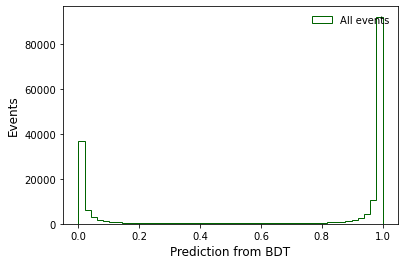

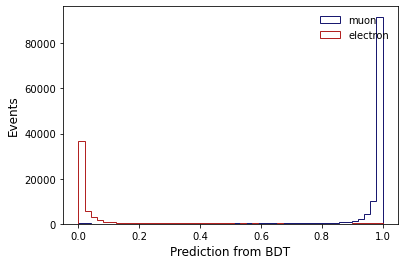

In [86]:
# plot all predictions (both signal and background)
plt.figure();
plt.hist(predictions,bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

# plot signal and background separately
plt.figure();
plt.hist(predictions[test.get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='muon');
plt.hist(predictions[~(test.get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='electron');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

/tmp/ipykernel_1486/375920219.py:11: RuntimeWarning: invalid value encountered in divide
  plt.plot(nsignal/len(val_df[val_df.pdg_id == 13]),nsignal/(nsignal + nbackground),'o-',color='blueviolet');
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


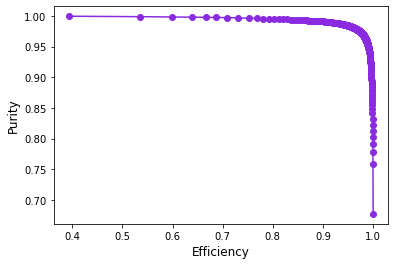

In [87]:
# choose score cuts:
cuts = np.linspace(0,1,500);
nsignal = np.zeros(len(cuts));
nbackground = np.zeros(len(cuts));
for i,cut in enumerate(cuts):
    nsignal[i] = len(np.where(predictions[test.get_label().astype(bool)] > cut)[0]);
    nbackground[i] = len(np.where(predictions[~(test.get_label().astype(bool))] > cut)[0]);
    
# plot efficiency vs. purity (ROC curve)
plt.figure();
plt.plot(nsignal/len(val_df[val_df.pdg_id == 13]),nsignal/(nsignal + nbackground),'o-',color='blueviolet');
# make the plot readable
plt.xlabel('Efficiency',fontsize=12);
plt.ylabel('Purity',fontsize=12);
plt.legend(frameon=False);

Interestingly, xgboost makes a decision tree with a much greater emphasis on the x and y poition of the particle when compared to the sklearn BDTree a few lines below.


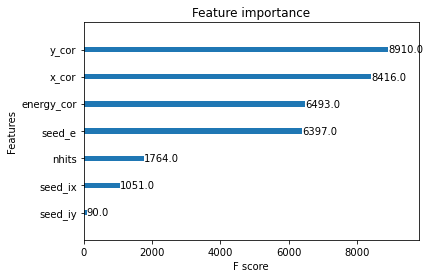

In [88]:
xgb.plot_importance(booster,grid=False); #use either the cor or the uncor values, but probably not both 
print("Interestingly, xgboost makes a decision tree with a much greater emphasis on the x and y poition of the particle when compared to the sklearn BDTree a few lines below.")

In [95]:
clf = tree.DecisionTreeClassifier() 
X_train = train_df.drop(columns=['pdg_id']) #remove the 'truth' aka pdg_id column from the features dataset
X_test = val_df.drop(columns=['pdg_id']) #same thing, but for the df for testing the model
Y_train = train_df['pdg_id'] #this is the df containing the truth values for the X_train features, aka which particle they are
Y_test = val_df['pdg_id'] #contains truth values for the test set 

#check to make sure we have the same number of entries 
X_train.shape[0]==Y_train.shape[0]
X_test.shape[0]==Y_test.shape[0]
#we do the fitting here
clf.fit(X_train, Y_train)
#test the model 
clf_pred = clf.predict(X_test)
print("Training set score (should be very close to 1): %f" % clf.score(X_train, Y_train))
print("Test set score (how accurate the model is at classifying mu-/e-): %f" % clf.score(X_test, Y_test))
print(f"So using 170k test datapoints, we on average have a {(1-clf.score(X_test,Y_test))*100} % error")
#would now try to find the smallest decision tree that still gets a similar error rate to the huge tree 

Training set score (should be very close to 1): 0.999880
Test set score (how accurate the model is at classifying mu-/e-): 0.944666
So using 170k test datapoints, we on average have a 5.533403764668465 % error


sklearn's decision tree classifier makes the vast majority of particle classification decisions using the energy feature, not x and y like xgboost.


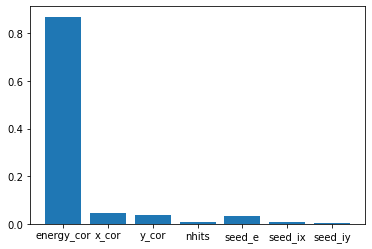

In [90]:
plt.bar(clf.feature_names_in_,clf.feature_importances_)
print("sklearn's decision tree classifier makes the vast majority of particle classification decisions using the energy feature, not x and y like xgboost.")

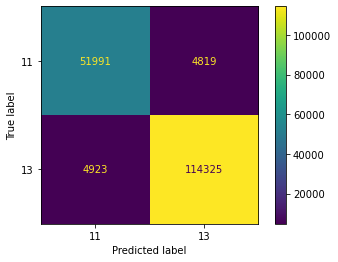

In [99]:
#create and plot the confusion matrix for the normal decision tree
clf_cmatrix = sklearn.metrics.confusion_matrix(Y_test, clf_pred, labels=clf.classes_)
display = sklearn.metrics.ConfusionMatrixDisplay(clf_cmatrix, display_labels=clf.classes_)
display.plot()
plt.show()

In [91]:
#uncomment the lines below to create a pdf of tree visualization 

#tree.plot_tree(clf)
#import graphviz 
#dot_data = tree.export_graphviz(clf, out_file=None)
#graph = graphviz.Source(dot_data) 
#graph.render('mytree') 

In [92]:
#for fun, I test a single feather file that contains both electrons and muons, and see how accurate the above model is.
emu_df= pd.read_feather("emu.feather") 

In [93]:
#emu_df.dtypes
emu_df.tail()
emu_df.tail()
#filtered_emu=emu_df.filter("pdg_id=11")
emu_filtered = emu_df.loc[emu_df['pdg_id'].between(10,14)]
emu_elec = emu_filtered.loc[emu_filtered['pdg_id']==11]
emu_muons = emu_filtered.loc[emu_filtered['pdg_id']==13]

#emu_filtered.shape
#emu_elec.shape
emu_train = emu_filtered[0:3000]
emu_test = emu_filtered[3000:]
TRAIN = emu_train.drop(columns=['pdg_id'])
TEST = emu_test.drop(columns=['pdg_id'])
TRUTH_TRAIN = emu_train['pdg_id']
TRUTH_TEST = emu_test['pdg_id']
#filtered_emu.tail()
#need to filter dataframe to contain only pdg = 13, 11
#then need to make this into a emu_train and emu_test to test clf


In [94]:
clf.fit(TRAIN, TRUTH_TRAIN)
#test the model 
clf.predict(TEST)
print("Training set score (should be very close to 1): %f" % clf.score(TRAIN, TRUTH_TRAIN))
print("Test set score (how accurate the model is at classifying mu/e-): %f" % clf.score(TEST, TRUTH_TEST))
print(f"So using {emu_test.shape[0]} datapoints, we on average have a {(1-clf.score(TEST,TRUTH_TEST))*100} % error")

Training set score (should be very close to 1): 1.000000
Test set score (how accurate the model is at classifying mu/e-): 0.993517
So using 617 datapoints, we on average have a 0.648298217179899 % error
